In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import os
import sys
import re
import sys

import fna

import pipeline as pipeline

sys.path.append("../demyelination/") # we need this to successfully read pickle files
sys.path.append("../") # we need this to successfully read pickle files

In [37]:
def stimanalysis(dataobjs, parts=('MGN', 'eA1')):
    timeframes = ()
    
    df = pd.DataFrame()

    for part in parts:
        for data in dataobjs:
            neuron_idx_start = int (list(data.spikeobj[part].spiketrains.keys())[0])
            stim_neuron_idx = int (len(data.spikeobj[part].spiketrains.keys()) * 1/5) +neuron_idx_start
            neuron_idx_end = int (list(data.spikeobj[part].spiketrains.keys())[-1])
            
            tmp = data.params
            tmp = tmp.update({
                "brainPart" : part,
                "pre_stim_meanrate" : data.spikeobj[part].time_slice(1800, 2000).id_slice(np.arange(neuron_idx_start, stim_neuron_idx+1)).mean_rate(),
                "peri_stim_meanrate" : data.spikeobj[part].time_slice(2000, 2100).id_slice(np.arange(neuron_idx_start, stim_neuron_idx+1)).mean_rate(),
                "post_stim_meanrate" : data.spikeobj[part].time_slice(2200, 2600).id_slice(np.arange(neuron_idx_start, stim_neuron_idx+1)).mean_rate(),
                
                "pre_nonstim_meanrate" : data.spikeobj[part].time_slice(1800, 2000).id_slice(np.arange(stim_neuron_idx, neuron_idx_end+1)).mean_rate(),
                "peri_nonstim_meanrate" : data.spikeobj[part].time_slice(2000, 2100).id_slice(np.arange(stim_neuron_idx, neuron_idx_end+1)).mean_rate(),
                "post_nonstim_meanrate" : data.spikeobj[part].time_slice(2200, 2600).id_slice(np.arange(stim_neuron_idx, neuron_idx_end+1)).mean_rate()
            })
            df = df.append(data.params, ignore_index=True)

    return df

## MGN Stim

MEAN SPIKING RATE:  8.49 19.32 8.142
MEAN SPIKING RATE:  12.3225 19.565 12.2205
PEARSON COEFF:  -0.007728428324383412 0.0318909904605619 0.002294753952150341
PEARSON COEFF:  0.04107705398261805 0.04593792185459462 -0.0049510857908543785


Text(0.5, 1.0, 'Stimulation of the MGN at 4.67Hz with a weight of 15 from 500ms to 600ms. Mean Firing Rate of eA1 Before Stim: 8.5Hz, During: 19.3Hz, After: 8.1HzPearson Pairwise Coeff of eA1 Before Stim: 0.02, During: 0.02, After: 0.0007')

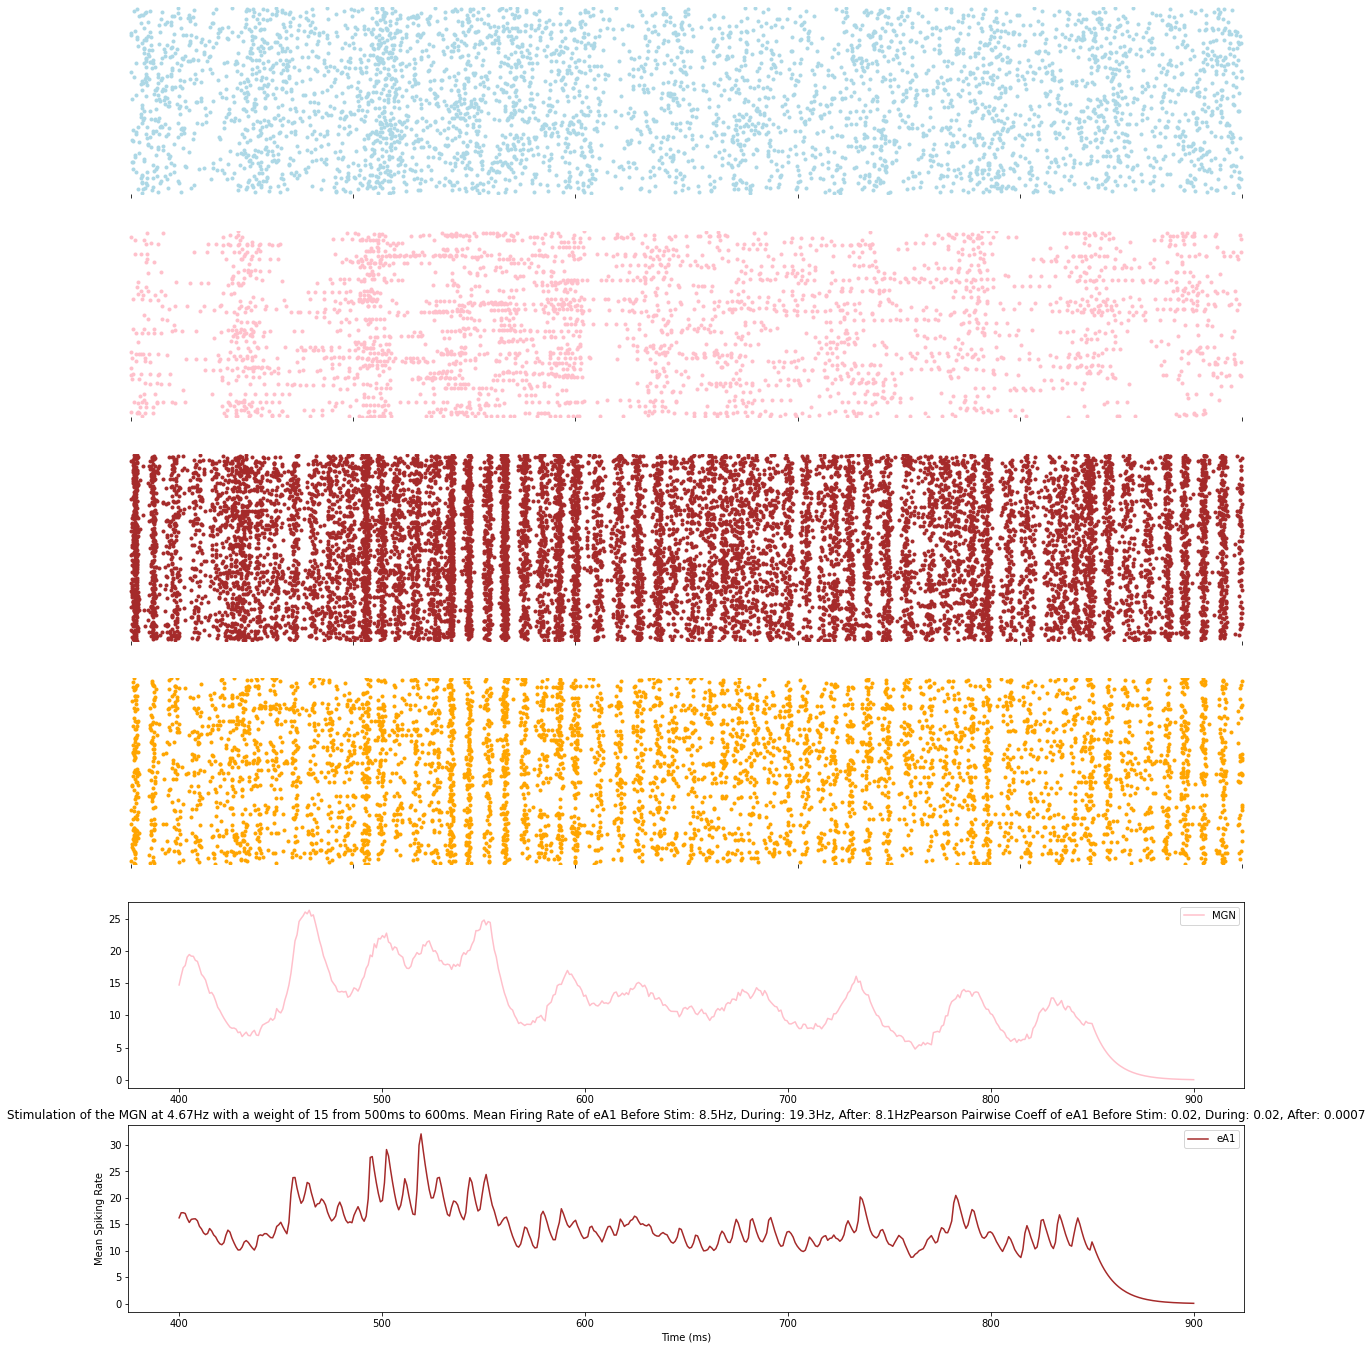

In [3]:
pth = "../demyelination/data/mgn20hz-highweight/activity/"
#f = ['spk_mgnstim-200s_nuX_stim=10.0_w_th_stimscale=31.0']
f = ['spk_mgn20hz-highweight_w_th_stimscale=16.0_scale_w=15.0_stim_dur=100.0']

p = pd.read_pickle(pth + f[0])
fig, ax = plt.subplots(nrows=6, ncols=1)
fig.set_size_inches(20, 24)
#plt.ylim(0, 45)
#plt.title(f[0])

for x in [0, 1, 2, 3]:
    ax[x].set_frame_on(False)
    ax[x].tick_params(labelbottom=False)
    ax[x].get_yaxis().set_ticks([])

tstart = 400
tstop = 900
    
p.spikeobj['TRN'].time_slice(tstart, tstop).raster_plot(ax=ax[0], dt=10, display=False, color='lightblue')
p.spikeobj['MGN'].time_slice(tstart, tstop).raster_plot(ax=ax[1], dt=10, display=False, color='pink')
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax[2], dt=10, display=False, color='brown')
p.spikeobj['iA1'].time_slice(tstart, tstop).raster_plot(ax=ax[3], dt=10, display=False, color='orange')

x, y = pipeline.smoothedspikes(p.spikeobj['TRN'].time_slice(tstart, tstop))
#ax[4].plot(x, y, label='TRN', c='lightblue')

x, y = pipeline.smoothedspikes(p.spikeobj['MGN'].time_slice(tstart, tstop))
ax[4].plot(x, y, label='MGN', c='pink')

x, y = pipeline.smoothedspikes(p.spikeobj['eA1'].time_slice(tstart, tstop))
ax[5].plot(x, y, label='eA1', c='brown')

x, y = pipeline.smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
#ax[4].plot(x, y, label='iA1', c='orange')

plt.xlabel("Time (ms)")
plt.ylabel("Mean Spiking Rate")
#plt.axhline(25, c='brown', label="y=25")

#plt.xticks(range(0, 60+1, 10), range(tstart, tstop+1, 100))
ax[2].spines.right.set_visible(False)
ax[2].spines.top.set_visible(False)

ax[4].legend()
ax[5].legend()

#plt.show()

print("MEAN SPIKING RATE: ", p.spikeobj['MGN'].time_slice(300, 500).mean_rate(), \
      p.spikeobj['MGN'].time_slice(500, 600).mean_rate(),\
      p.spikeobj['MGN'].time_slice(1000, 2000).mean_rate())
print("MEAN SPIKING RATE: ", p.spikeobj['eA1'].time_slice(300, 500).mean_rate(), \
      p.spikeobj['eA1'].time_slice(500, 600).mean_rate(),\
      p.spikeobj['eA1'].time_slice(1000, 2000).mean_rate())
print("PEARSON COEFF: ", p.spikeobj['eA1'].time_slice(300, 500).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['eA1'].time_slice(500, 600).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['eA1'].time_slice(1000, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
print("PEARSON COEFF: ", p.spikeobj['MGN'].time_slice(300, 500).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['MGN'].time_slice(500, 600).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['MGN'].time_slice(1000, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
# print("CV_ISI: ", p.spikeobj['MGN'].time_slice(2000, 3000).cv_isi().mean(), p.spikeobj['TRN'].time_slice(2000, 3000).cv_isi().mean())
# print("PEARSON COEFF: ", p.metrics['pearsoncoeff']['MGN'], p.metrics['pearsoncoeff']['TRN'])
#np.mean(p.spikeobj['MGN'].averaged_instantaneous_rate(resolution=1., kernel=kernel, norm=1000))

plt.title("Stimulation of the MGN at 4.67Hz with a weight of 15 from 500ms to 600ms. \
Mean Firing Rate of eA1 Before Stim: 8.5Hz, During: 19.3Hz, After: 8.1Hz\
Pearson Pairwise Coeff of eA1 Before Stim: 0.02, During: 0.02, After: 0.0007")


MEAN SPIKING RATE:  4.381333333333334 10.46 4.419
MEAN SPIKING RATE:  10.605666666666666 15.675 10.678
PEARSON COEFF:  0.004027615218635516 0.012273418720669088 0.0017038360733884095
PEARSON COEFF:  -0.002658245844172639 0.01676712794581709 0.0113786377351634


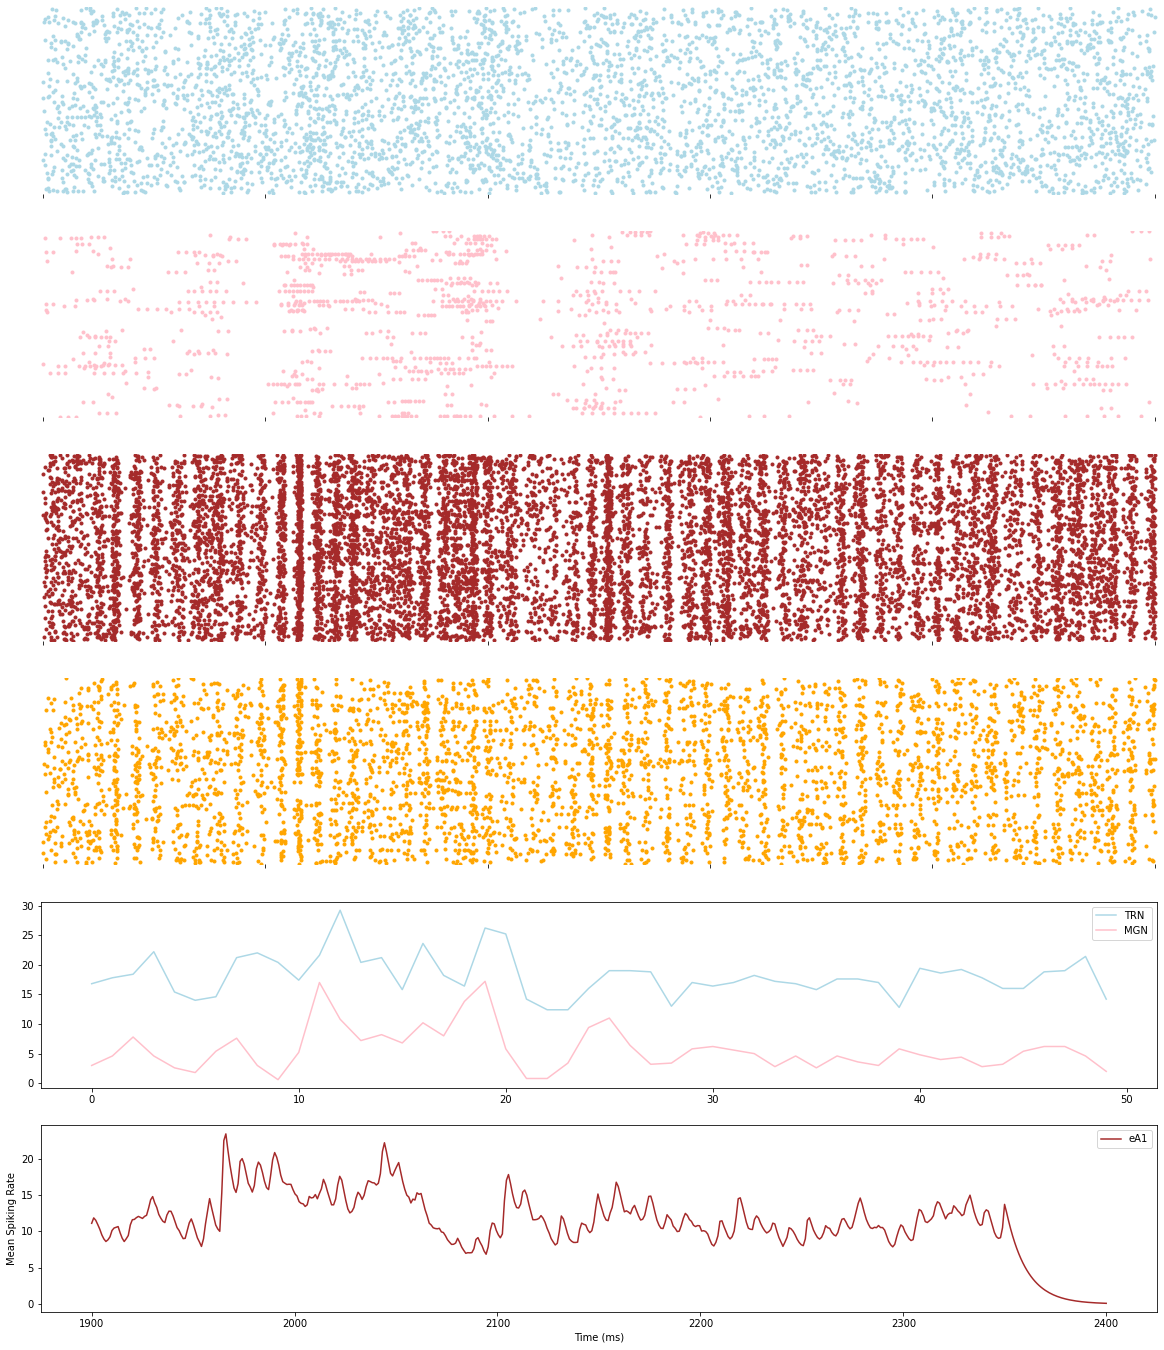

In [4]:
pth = "../demyelination/data/weakcoupling/activity/"
f = ['spk_weakcoupling_scale_w=15.0_gamma_th=40.0_wX_TRN=1.4']

p = pd.read_pickle(pth + f[0])
fig, ax = plt.subplots(nrows=6, ncols=1)
fig.set_size_inches(20, 24)
#plt.ylim(0, 45)
#plt.title(f[0])

for x in [0, 1, 2, 3]:
    ax[x].set_frame_on(False)
    ax[x].tick_params(labelbottom=False)
    ax[x].get_yaxis().set_ticks([])

tstart = 1900
tstop = 2400
    
p.spikeobj['TRN'].time_slice(tstart, tstop).raster_plot(ax=ax[0], dt=10, display=False, color='lightblue')
p.spikeobj['MGN'].time_slice(tstart, tstop).raster_plot(ax=ax[1], dt=10, display=False, color='pink')
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax[2], dt=10, display=False, color='brown')
p.spikeobj['iA1'].time_slice(tstart, tstop).raster_plot(ax=ax[3], dt=10, display=False, color='orange')

# x, y = smoothedspikes(p.spikeobj['TRN'].time_slice(tstart, tstop))
# ax[4].plot(x, y, label='TRN', c='lightblue')
ax[4].plot(p.spikeobj['TRN'].time_slice(tstart, tstop).firing_rate(10, average=True), label='TRN', c='lightblue')

# x, y = smoothedspikes(p.spikeobj['MGN'].time_slice(tstart, tstop))
# ax[4].plot(x, y, label='MGN', c='pink')
ax[4].plot(p.spikeobj['MGN'].time_slice(tstart, tstop).firing_rate(10, average=True), label='MGN', c='pink')

x, y = pipeline.smoothedspikes(p.spikeobj['eA1'].time_slice(tstart, tstop))
ax[5].plot(x, y, label='eA1', c='brown')

x, y = pipeline.smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
#ax[4].plot(x, y, label='iA1', c='orange')

plt.xlabel("Time (ms)")
plt.ylabel("Mean Spiking Rate")
#plt.axhline(25, c='brown', label="y=25")

#plt.xticks(range(0, 60+1, 10), range(tstart, tstop+1, 100))
ax[2].spines.right.set_visible(False)
ax[2].spines.top.set_visible(False)

ax[4].legend()
ax[5].legend()

#plt.show()

print("MEAN SPIKING RATE: ", p.spikeobj['MGN'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['MGN'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['MGN'].time_slice(3000, 5000).mean_rate())
print("MEAN SPIKING RATE: ", p.spikeobj['eA1'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['eA1'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['eA1'].time_slice(3000, 5000).mean_rate())
print("PEARSON COEFF: ", p.spikeobj['eA1'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['eA1'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['eA1'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
print("PEARSON COEFF: ", p.spikeobj['MGN'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['MGN'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['MGN'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
# print("CV_ISI: ", p.spikeobj['MGN'].time_slice(2000, 3000).cv_isi().mean(), p.spikeobj['TRN'].time_slice(2000, 3000).cv_isi().mean())
# print("PEARSON COEFF: ", p.metrics['pearsoncoeff']['MGN'], p.metrics['pearsoncoeff']['TRN'])
#np.mean(p.spikeobj['MGN'].averaged_instantaneous_rate(resolution=1., kernel=kernel, norm=1000))

# plt.title("Stimulation of the MGN at 4.67Hz with a weight of 15 from 500ms to 600ms. \
# Mean Firing Rate of eA1 Before Stim: 8.5Hz, During: 19.3Hz, After: 8.1Hz\
# Pearson Pairwise Coeff of eA1 Before Stim: 0.02, During: 0.02, After: 0.0007")

# plt.savefig("/home/pbr-student/Downloads/thesis-plots/mgnstim-stimscale=15.pdf")

MGN MEAN SPIKING RATE:  8.046666666666667 18.72 7.96
eA1 MEAN SPIKING RATE:  11.773333333333333 16.885 12.08625
eA1 PEARSON COEFF:  -0.003187807190941409 0.01943305751823174 0.004410543355118044
MGN PEARSON COEFF:  0.003693306359306232 0.010540780561065173 0.005292162008350131


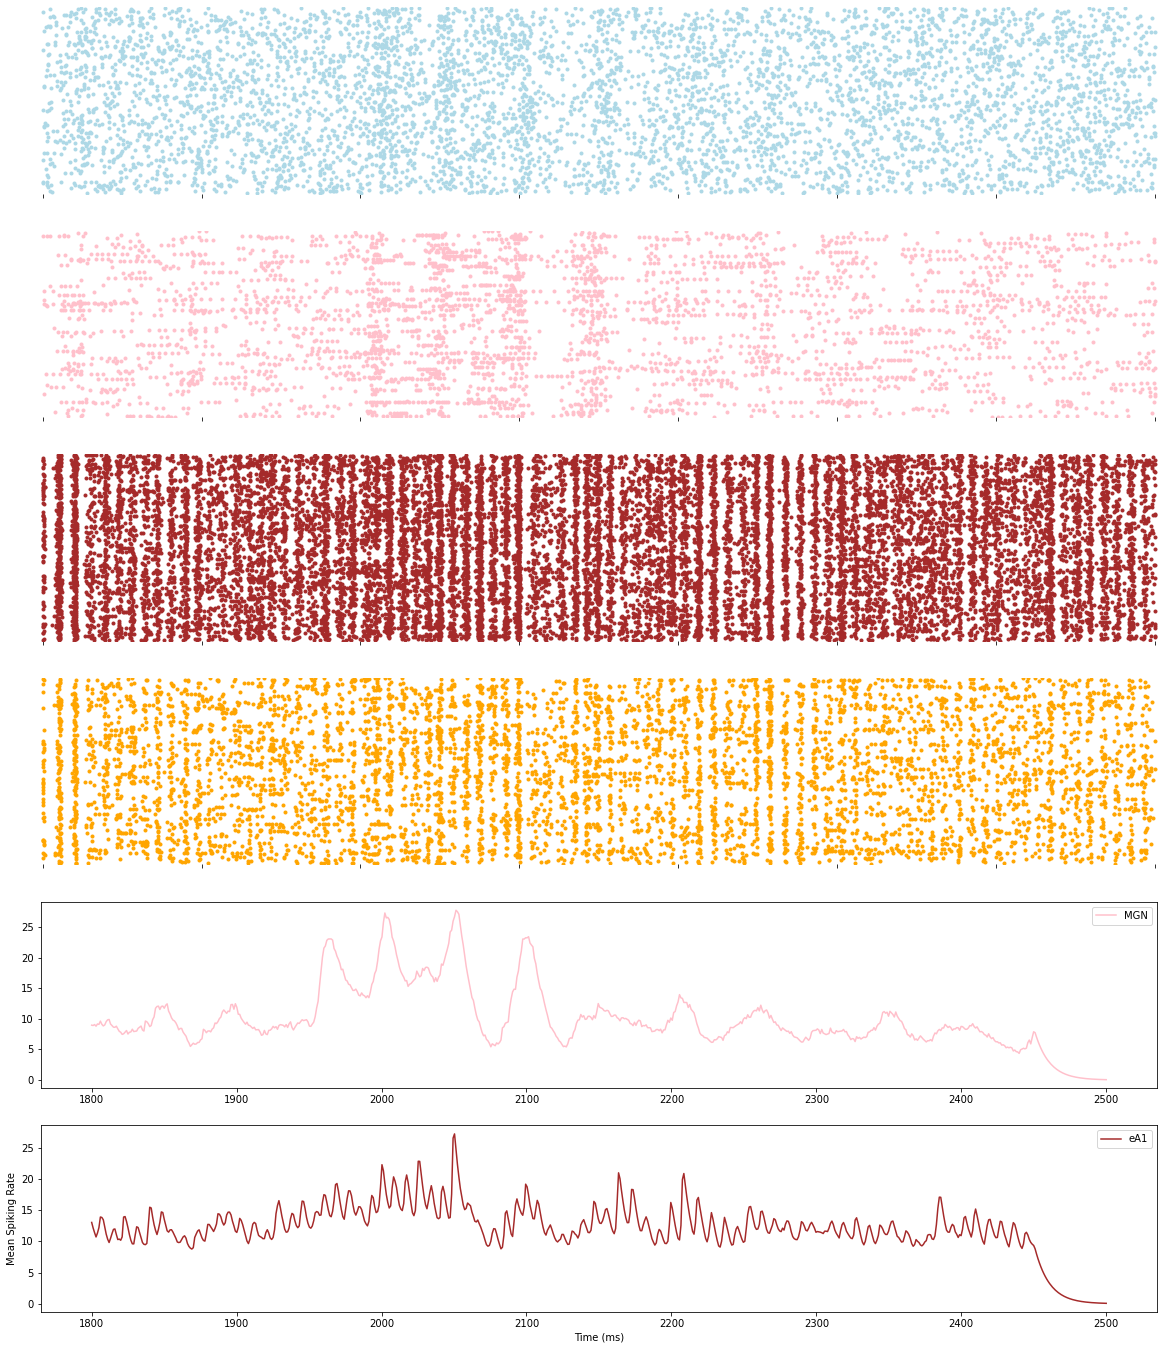

In [5]:
pth = "../demyelination/data/weakaone/activity/"
f = ['spk_weakaone_nuX_aone=30.0_gamma_aone=15.0_w_aone=3.0_stim_dur=100.0']

p = pd.read_pickle(pth + f[0])
fig, ax = plt.subplots(nrows=6, ncols=1)
fig.set_size_inches(20, 24)
#plt.ylim(0, 45)
#plt.title(f[0])

for x in [0, 1, 2, 3]:
    ax[x].set_frame_on(False)
    ax[x].tick_params(labelbottom=False)
    ax[x].get_yaxis().set_ticks([])

tstart = 1800
tstop = 2500
    
p.spikeobj['TRN'].time_slice(tstart, tstop).raster_plot(ax=ax[0], dt=10, display=False, color='lightblue')
p.spikeobj['MGN'].time_slice(tstart, tstop).raster_plot(ax=ax[1], dt=10, display=False, color='pink')
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax[2], dt=10, display=False, color='brown')
p.spikeobj['iA1'].time_slice(tstart, tstop).raster_plot(ax=ax[3], dt=10, display=False, color='orange')

x, y = pipeline.smoothedspikes(p.spikeobj['TRN'].time_slice(tstart, tstop))
#ax[4].plot(x, y, label='TRN', c='lightblue')

x, y = pipeline.smoothedspikes(p.spikeobj['MGN'].time_slice(tstart, tstop))
ax[4].plot(x, y, label='MGN', c='pink')

x, y = pipeline.smoothedspikes(p.spikeobj['eA1'].time_slice(tstart, tstop))
ax[5].plot(x, y, label='eA1', c='brown')

x, y = pipeline.smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
#ax[4].plot(x, y, label='iA1', c='orange')

plt.xlabel("Time (ms)")
plt.ylabel("Mean Spiking Rate")
#plt.axhline(25, c='brown', label="y=25")

#plt.xticks(range(0, 60+1, 10), range(tstart, tstop+1, 100))
ax[2].spines.right.set_visible(False)
ax[2].spines.top.set_visible(False)

ax[4].legend()
ax[5].legend()

#plt.show()

print("MGN MEAN SPIKING RATE: ", p.spikeobj['MGN'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['MGN'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['MGN'].time_slice(3000, 5000).mean_rate())
print("eA1 MEAN SPIKING RATE: ", p.spikeobj['eA1'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['eA1'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['eA1'].time_slice(3000, 5000).mean_rate())
print("eA1 PEARSON COEFF: ", p.spikeobj['eA1'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['eA1'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['eA1'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
print("MGN PEARSON COEFF: ", p.spikeobj['MGN'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['MGN'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['MGN'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
# print("CV_ISI: ", p.spikeobj['MGN'].time_slice(2000, 3000).cv_isi().mean(), p.spikeobj['TRN'].time_slice(2000, 3000).cv_isi().mean())
# print("PEARSON COEFF: ", p.metrics['pearsoncoeff']['MGN'], p.metrics['pearsoncoeff']['TRN'])
#np.mean(p.spikeobj['MGN'].averaged_instantaneous_rate(resolution=1., kernel=kernel, norm=1000))

# plt.title("Stimulation of the MGN at 4.67Hz with a weight of 15 from 500ms to 600ms. \
# Mean Firing Rate of eA1 Before Stim: 8.5Hz, During: 19.3Hz, After: 8.1Hz\
# Pearson Pairwise Coeff of eA1 Before Stim: 0.02, During: 0.02, After: 0.0007")

# plt.savefig("/home/pbr-student/Downloads/thesis-plots/mgnstim-stimscale=15.pdf")

MGN MEAN SPIKING RATE:  4.38 9.68 4.604
eA1 MEAN SPIKING RATE:  13.273 18.345 13.5315
eA1 PEARSON COEFF:  0.01298460645035265 0.025357966192174827 0.010262421587329375
MGN PEARSON COEFF:  0.0051660404911668106 0.049745721138626624 -0.0010869631656548662


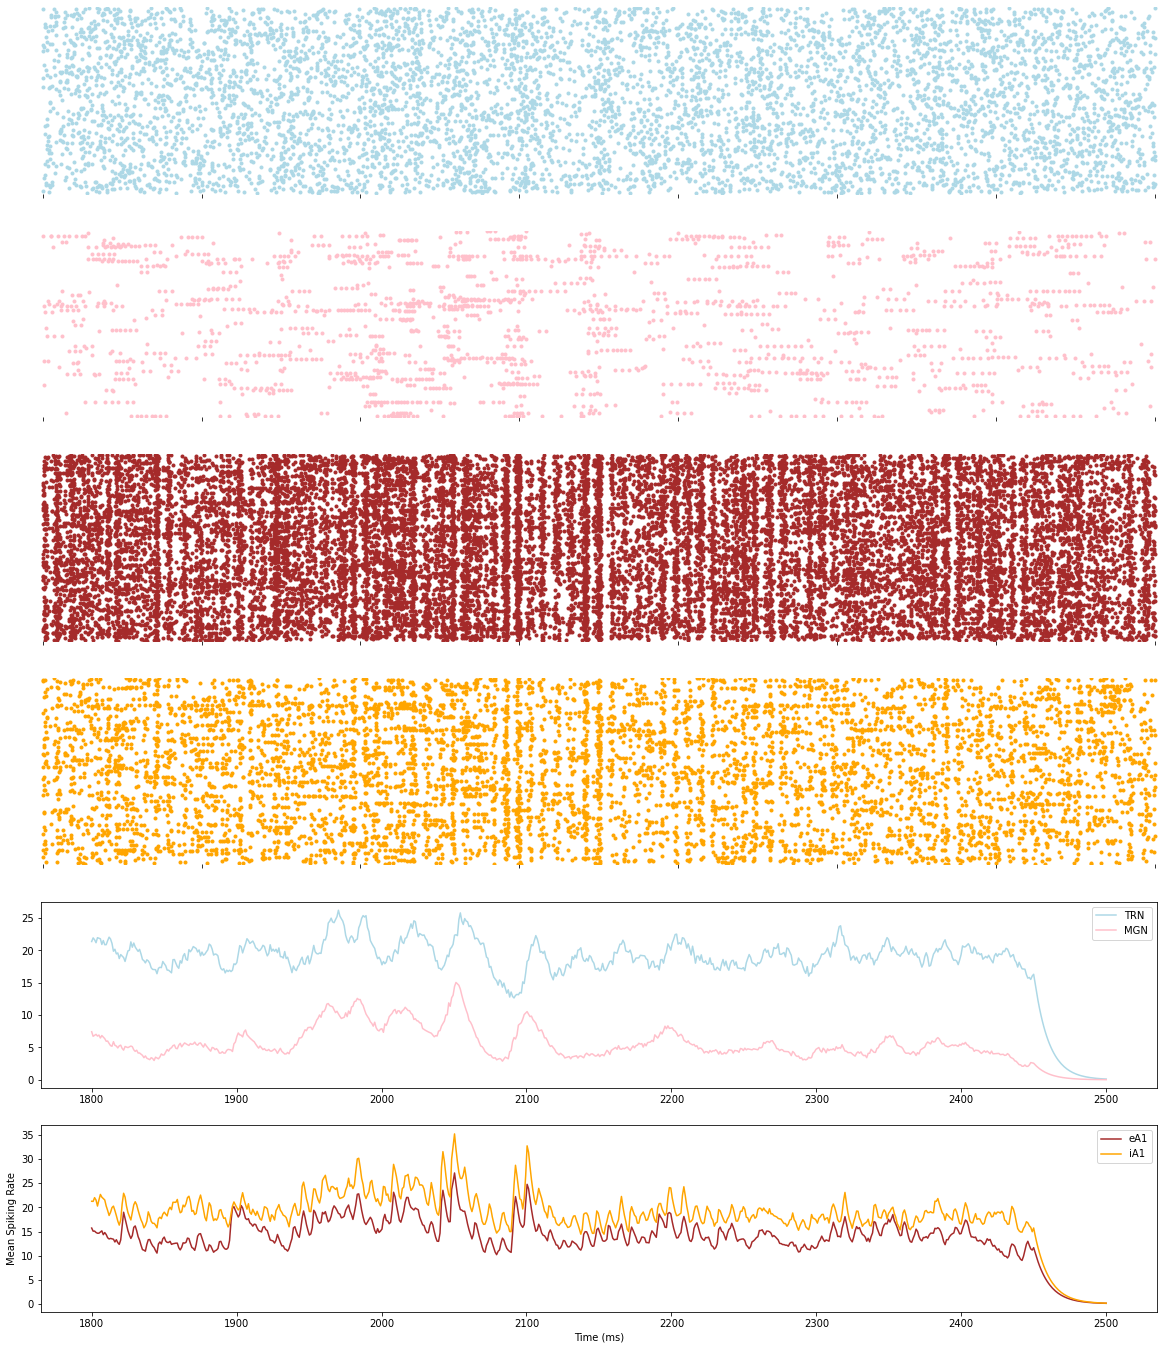

In [6]:
pth = "../demyelination/data/highergamma/activity/"
f = ['spk_highergamma_scale_w=30.0_gamma_th=40.0_nuX_aone=30.0_gamma_aone=15.0_wX_TRN=1.4']

p = pd.read_pickle(pth + f[0])
fig, ax = plt.subplots(nrows=6, ncols=1)
fig.set_size_inches(20, 24)
#plt.ylim(0, 45)
#plt.title(f[0])

for x in [0, 1, 2, 3]:
    ax[x].set_frame_on(False)
    ax[x].tick_params(labelbottom=False)
    ax[x].get_yaxis().set_ticks([])

tstart = 1800
tstop = 2500
    
p.spikeobj['TRN'].time_slice(tstart, tstop).raster_plot(ax=ax[0], dt=10, display=False, color='lightblue')
p.spikeobj['MGN'].time_slice(tstart, tstop).raster_plot(ax=ax[1], dt=10, display=False, color='pink')
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax[2], dt=10, display=False, color='brown')
p.spikeobj['iA1'].time_slice(tstart, tstop).raster_plot(ax=ax[3], dt=10, display=False, color='orange')

x, y = pipeline.smoothedspikes(p.spikeobj['TRN'].time_slice(tstart, tstop))
ax[4].plot(x, y, label='TRN', c='lightblue')

x, y = pipeline.smoothedspikes(p.spikeobj['MGN'].time_slice(tstart, tstop))
ax[4].plot(x, y, label='MGN', c='pink')

x, y = pipeline.smoothedspikes(p.spikeobj['eA1'].time_slice(tstart, tstop))
ax[5].plot(x, y, label='eA1', c='brown')

x, y = pipeline.smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
ax[5].plot(x, y, label='iA1', c='orange')

plt.xlabel("Time (ms)")
plt.ylabel("Mean Spiking Rate")
#plt.axhline(25, c='brown', label="y=25")

#plt.xticks(range(0, 60+1, 10), range(tstart, tstop+1, 100))
ax[2].spines.right.set_visible(False)
ax[2].spines.top.set_visible(False)

ax[4].legend()
ax[5].legend()

#plt.show()

print("MGN MEAN SPIKING RATE: ", p.spikeobj['MGN'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['MGN'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['MGN'].time_slice(3000, 5000).mean_rate())
print("eA1 MEAN SPIKING RATE: ", p.spikeobj['eA1'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['eA1'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['eA1'].time_slice(3000, 5000).mean_rate())
print("eA1 PEARSON COEFF: ", p.spikeobj['eA1'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['eA1'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['eA1'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
print("MGN PEARSON COEFF: ", p.spikeobj['MGN'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['MGN'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['MGN'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
# print("CV_ISI: ", p.spikeobj['MGN'].time_slice(2000, 3000).cv_isi().mean(), p.spikeobj['TRN'].time_slice(2000, 3000).cv_isi().mean())
# print("PEARSON COEFF: ", p.metrics['pearsoncoeff']['MGN'], p.metrics['pearsoncoeff']['TRN'])
#np.mean(p.spikeobj['MGN'].averaged_instantaneous_rate(resolution=1., kernel=kernel, norm=1000))

# plt.title("Stimulation of the MGN at 4.67Hz with a weight of 15 from 500ms to 600ms. \
# Mean Firing Rate of eA1 Before Stim: 8.5Hz, During: 19.3Hz, After: 8.1Hz\
# Pearson Pairwise Coeff of eA1 Before Stim: 0.02, During: 0.02, After: 0.0007")

# plt.savefig("/home/pbr-student/Downloads/thesis-plots/mgnstim-stimscale=15.pdf")

MGN MEAN SPIKING RATE:  7.616 20.04 7.871
eA1 MEAN SPIKING RATE:  10.652333333333335 16.48 10.8015
eA1 PEARSON COEFF:  0.006122053566329713 0.04184450631639169 0.001738701724181918
MGN PEARSON COEFF:  -0.001788322513372327 0.051744625018475834 0.0017607230742758173


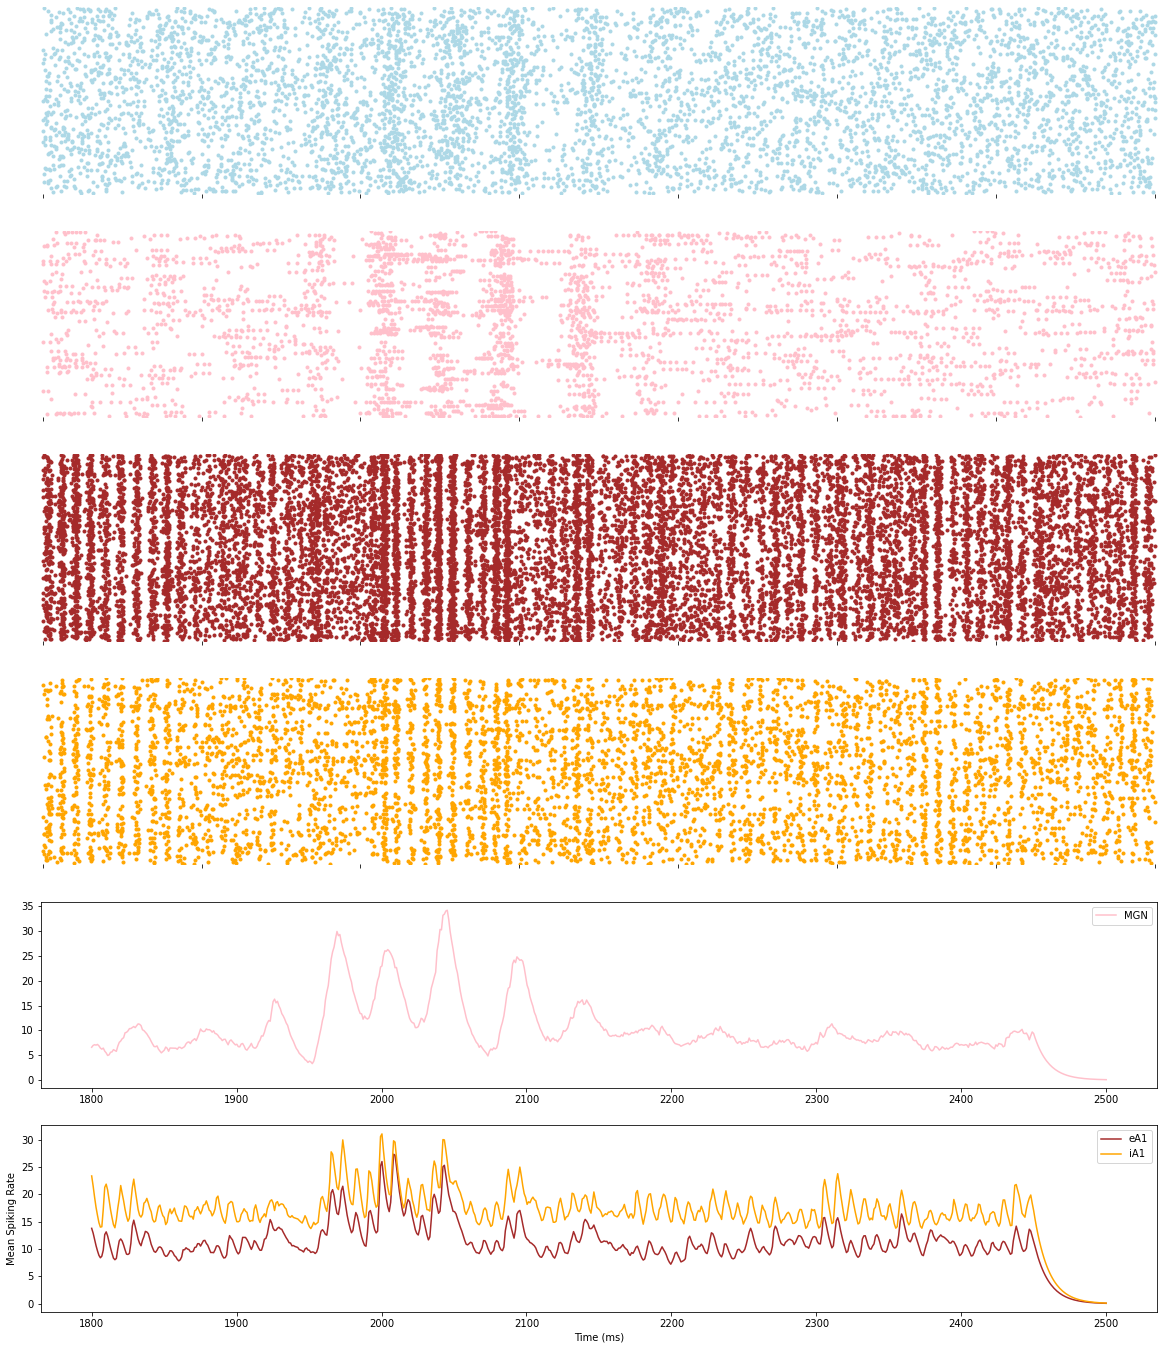

In [19]:
pth = "../demyelination/data/highergamma/activity/"
#f = ['spk_highergamma_scale_w=10.0_gamma_th=20.0_nuX_aone=25.0_gamma_aone=9.0_nuX_th=20.0'] good activity levels
f = ['spk_highergamma_scale_w=10.0_gamma_th=20.0_nuX_aone=25.0_gamma_aone=9.0_nuX_th=20.0']

p = pd.read_pickle(pth + f[0])
fig, ax = plt.subplots(nrows=6, ncols=1)
fig.set_size_inches(20, 24)
#plt.ylim(0, 45)
#plt.title(f[0])

for x in [0, 1, 2, 3]:
    ax[x].set_frame_on(False)
    ax[x].tick_params(labelbottom=False)
    ax[x].get_yaxis().set_ticks([])

tstart = 1800
tstop = 2500
    
p.spikeobj['TRN'].time_slice(tstart, tstop).raster_plot(ax=ax[0], dt=10, display=False, color='lightblue')
p.spikeobj['MGN'].time_slice(tstart, tstop).raster_plot(ax=ax[1], dt=10, display=False, color='pink')
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax[2], dt=10, display=False, color='brown')
p.spikeobj['iA1'].time_slice(tstart, tstop).raster_plot(ax=ax[3], dt=10, display=False, color='orange')

x, y = pipeline.smoothedspikes(p.spikeobj['TRN'].time_slice(tstart, tstop))
#ax[5].plot(x, y, label='TRN', c='lightblue')

x, y = pipeline.smoothedspikes(p.spikeobj['MGN'].time_slice(tstart, tstop))
ax[4].plot(x, y, label='MGN', c='pink')

x, y = pipeline.smoothedspikes(p.spikeobj['eA1'].time_slice(tstart, tstop))
ax[5].plot(x, y, label='eA1', c='brown')

x, y = pipeline.smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
ax[5].plot(x, y, label='iA1', c='orange')

plt.xlabel("Time (ms)")
plt.ylabel("Mean Spiking Rate")
#plt.axhline(25, c='brown', label="y=25")

#plt.xticks(range(0, 60+1, 10), range(tstart, tstop+1, 100))
ax[2].spines.right.set_visible(False)
ax[2].spines.top.set_visible(False)

ax[4].legend()
ax[5].legend()

#plt.show()

print("MGN MEAN SPIKING RATE: ", p.spikeobj['MGN'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['MGN'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['MGN'].time_slice(3000, 5000).mean_rate())
print("eA1 MEAN SPIKING RATE: ", p.spikeobj['eA1'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['eA1'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['eA1'].time_slice(3000, 5000).mean_rate())
print("eA1 PEARSON COEFF: ", p.spikeobj['eA1'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['eA1'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['eA1'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
print("MGN PEARSON COEFF: ", p.spikeobj['MGN'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['MGN'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['MGN'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])


## Tonotopic

In [177]:
files = pipeline.readfiles("../demyelination/data/mgn20hz-tonotopic/activity/");
stimdf = stimanalysis(files, parts=('MGN', 'eA1', 'iA1'));

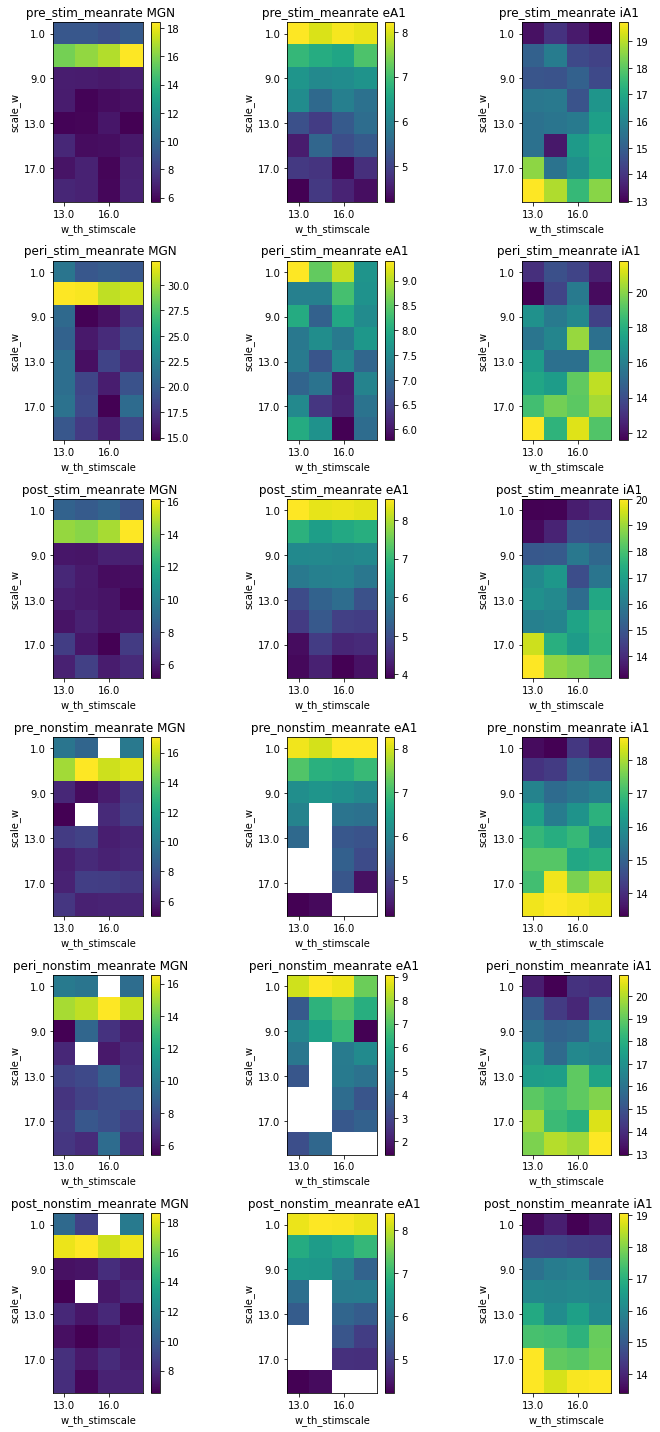

In [189]:
fig, ax = plt.subplots(nrows=6, ncols=3)

fig.set_size_inches(10, 20)
plt.subplots_adjust(left=0.01, right=0.03, top=0.03, bottom=0.02)

dfFilter = (stimdf.scale_w != 7) & (stimdf.scale_w != 5)
# dfFilter = [True] * stimdf.shape[0]

varone = "scale_w"
vartwo = "w_th_stimscale"

parts = ["MGN", 'eA1', "iA1"]

pipeline.makesubplot(stimdf[dfFilter], fig, ax[0], "pre_stim_meanrate", varone, vartwo, parts)

pipeline.makesubplot(stimdf[dfFilter], fig, ax[1], "peri_stim_meanrate", varone, vartwo, parts)

pipeline.makesubplot(stimdf[dfFilter], fig, ax[2], "post_stim_meanrate", varone, vartwo, parts)

pipeline.makesubplot(stimdf[dfFilter], fig, ax[3], "pre_nonstim_meanrate", varone, vartwo, parts)

pipeline.makesubplot(stimdf[dfFilter], fig, ax[4], "peri_nonstim_meanrate", varone, vartwo, parts)

pipeline.makesubplot(stimdf[dfFilter], fig, ax[5], "post_nonstim_meanrate", varone, vartwo, parts)

fig.tight_layout()

#plt.savefig("/home/pbr-student/Downloads/thesis-plots/adaptation-aone_winputaone=15.pdf")

MGN MEAN SPIKING RATE:  7.093333333333333 8.6 7.26
eA1 MEAN SPIKING RATE:  5.676 5.74 5.70575
eA1 PEARSON COEFF:  0.001347512179131567 0.007598319720127464 0.001140394524426162
MGN PEARSON COEFF:  0.007260079548079939 -0.023435612895276754 -0.0005725467888155656


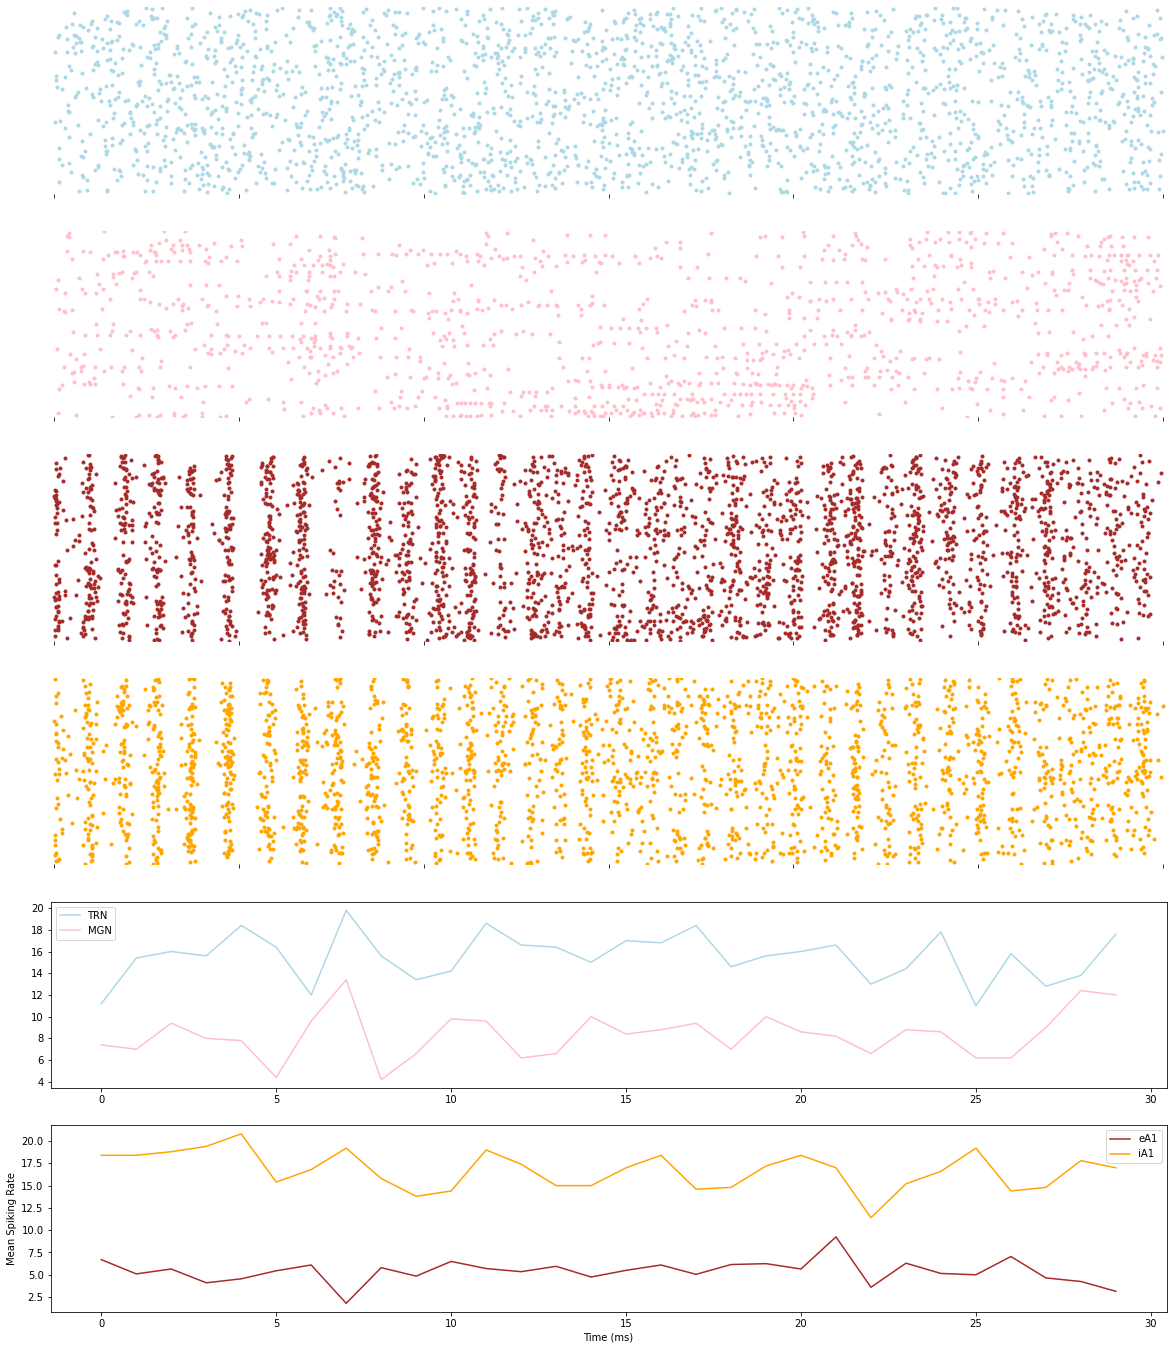

In [22]:
pth = "../demyelination/data/mgn20hz-tonotopic/activity/"
#f = ['spk_highergamma_scale_w=10.0_gamma_th=20.0_nuX_aone=25.0_gamma_aone=9.0_nuX_th=20.0'] good activity levels
f = ['spk_mgn20hz-tonotopic_w_th_stimscale=17.0_scale_w=11.0_stim_dur=100.0']

p = pd.read_pickle(pth + f[0])
fig, ax = plt.subplots(nrows=6, ncols=1)
fig.set_size_inches(20, 24)
#plt.ylim(0, 45)
#plt.title(f[0])

for x in [0, 1, 2, 3]:
    ax[x].set_frame_on(False)
    ax[x].tick_params(labelbottom=False)
    ax[x].get_yaxis().set_ticks([])

tstart = 1900
tstop = 2200
    
p.spikeobj['TRN'].time_slice(tstart, tstop).raster_plot(ax=ax[0], dt=10, display=False, color='lightblue')
p.spikeobj['MGN'].time_slice(tstart, tstop).raster_plot(ax=ax[1], dt=10, display=False, color='pink')
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax[2], dt=10, display=False, color='brown')
p.spikeobj['iA1'].time_slice(tstart, tstop).raster_plot(ax=ax[3], dt=10, display=False, color='orange')

x, y = pipeline.smoothedspikes(p.spikeobj['TRN'].time_slice(tstart, tstop))
#ax[5].plot(x, y, label='TRN', c='lightblue')
ax[4].plot(p.spikeobj['TRN'].time_slice(tstart, tstop).firing_rate(10, average=True), label='TRN', c='lightblue')

x, y = pipeline.smoothedspikes(p.spikeobj['MGN'].time_slice(tstart, tstop))
# ax[4].plot(x, y, label='MGN', c='pink')
ax[4].plot(p.spikeobj['MGN'].time_slice(tstart, tstop).firing_rate(10, average=True), label='MGN', c='pink')

x, y = pipeline.smoothedspikes(p.spikeobj['eA1'].time_slice(tstart, tstop))
# ax[5].plot(x, y, label='eA1', c='brown')
ax[5].plot(p.spikeobj['eA1'].time_slice(tstart, tstop).firing_rate(10, average=True), label='eA1', c='brown')

x, y = pipeline.smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
# ax[5].plot(x, y, label='iA1', c='orange')
ax[5].plot(p.spikeobj['iA1'].time_slice(tstart, tstop).firing_rate(10, average=True), label='iA1', c='orange')

plt.xlabel("Time (ms)")
plt.ylabel("Mean Spiking Rate")
#plt.axhline(25, c='brown', label="y=25")

#plt.xticks(range(0, 60+1, 10), range(tstart, tstop+1, 100))
ax[2].spines.right.set_visible(False)
ax[2].spines.top.set_visible(False)

ax[4].legend()
ax[5].legend()

#plt.show()

print("MGN MEAN SPIKING RATE: ", p.spikeobj['MGN'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['MGN'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['MGN'].time_slice(3000, 5000).mean_rate())
print("eA1 MEAN SPIKING RATE: ", p.spikeobj['eA1'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['eA1'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['eA1'].time_slice(3000, 5000).mean_rate())
print("eA1 PEARSON COEFF: ", p.spikeobj['eA1'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['eA1'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['eA1'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
print("MGN PEARSON COEFF: ", p.spikeobj['MGN'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['MGN'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['MGN'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])


## mgn20hz-lowera1gamma
In order to address the oscillations in the CTX, a lower gamma was found separately and the used in experiments of MGN stimulation.

In [192]:
files = pipeline.readfiles("../demyelination/data/mgn20hz-lowera1gamma/activity/");
df = pipeline.preparestimdf(files);

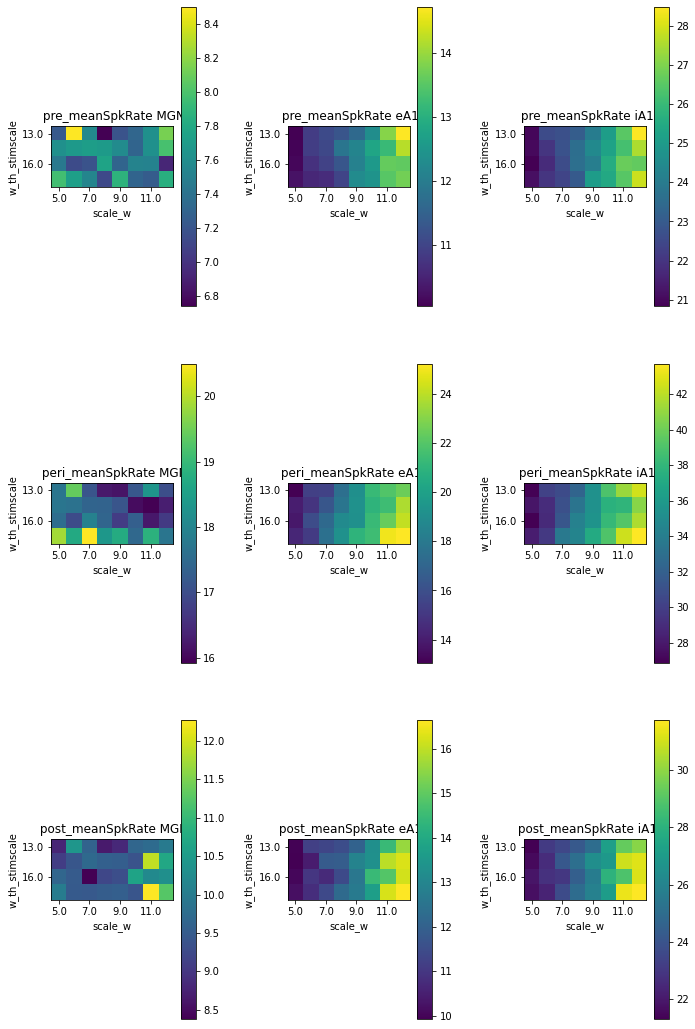

In [217]:
fig, ax = plt.subplots(nrows=3, ncols=3)

fig.set_size_inches(10, 15)
plt.subplots_adjust(left=0.01, right=0.03, top=0.03, bottom=0.02)

dfFilter = (df.nuX_aone == 15) & (df.gamma_aone == 2)
# dfFilter = [True] * df.shape[0]

varone = "w_th_stimscale"
vartwo = "scale_w"
parts = ["MGN", "eA1", "iA1"]

pipeline.makesubplot(df[dfFilter], fig, ax[0], "pre_meanSpkRate", varone, vartwo, parts)

pipeline.makesubplot(df[dfFilter], fig, ax[1], "peri_meanSpkRate", varone, vartwo, parts)

pipeline.makesubplot(df[dfFilter], fig, ax[2], "post_meanSpkRate", varone, vartwo, parts)

#makesubplot(df[dfFilter], fig, ax[3], "meanBurstSpikePercentageCerina", varone, vartwo, parts)

#makesubplot(df[dfFilter], fig, ax[4], "meanBurstSpikePercentageMIT", varone, vartwo, parts)

fig.tight_layout()


MGN MEAN SPIKING RATE:  7.954666666666666 15.94 93.218
eA1 MEAN SPIKING RATE:  15.014666666666669 23.655 121.96975
eA1 PEARSON COEFF:  0.02004840260512934 0.031654734386709536 0.9317472744598292


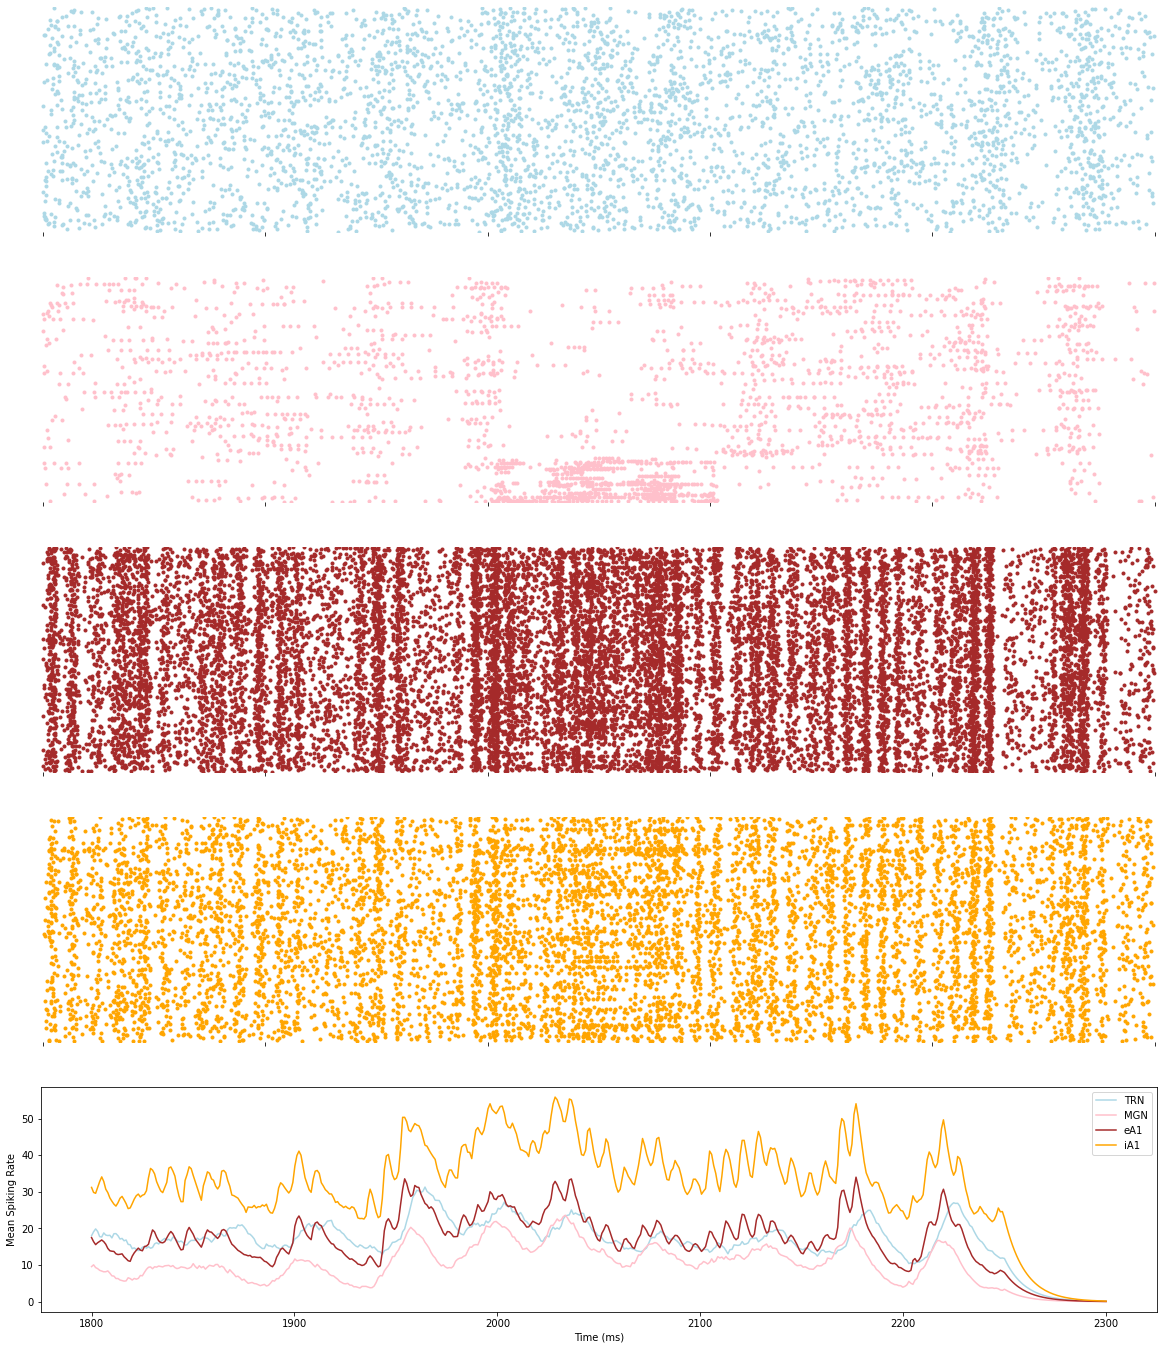

In [36]:
pth = "../demyelination/data/mgn20hz-lowera1gamma/activity/"
#f = ['spk_highergamma_scale_w=10.0_gamma_th=20.0_nuX_aone=25.0_gamma_aone=9.0_nuX_th=20.0'] good activity levels
f = ['spk_mgn20hz-lowera1gamma_w_th_stimscale=13.0_scale_w=12.0_nuX_aone=16.0_gamma_aone=2.0']

p = pd.read_pickle(pth + f[0])
fig, ax = plt.subplots(nrows=5, ncols=1)
fig.set_size_inches(20, 24)
#plt.ylim(0, 45)
#plt.title(f[0])

for x in [0, 1, 2, 3]:
    ax[x].set_frame_on(False)
    ax[x].tick_params(labelbottom=False)
    ax[x].get_yaxis().set_ticks([])

tstart = 1800
tstop = 2300
    
p.spikeobj['TRN'].time_slice(tstart, tstop).raster_plot(ax=ax[0], dt=10, display=False, color='lightblue')
p.spikeobj['MGN'].time_slice(tstart, tstop).raster_plot(ax=ax[1], dt=10, display=False, color='pink')
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax[2], dt=10, display=False, color='brown')
p.spikeobj['iA1'].time_slice(tstart, tstop).raster_plot(ax=ax[3], dt=10, display=False, color='orange')

x, y = pipeline.smoothedspikes(p.spikeobj['TRN'].time_slice(tstart, tstop))
ax[4].plot(x, y, label='TRN', c='lightblue')
# ax[4].plot(p.spikeobj['TRN'].time_slice(tstart, tstop).firing_rate(10, average=True), label='TRN', c='lightblue')

x, y = pipeline.smoothedspikes(p.spikeobj['MGN'].time_slice(tstart, tstop))
ax[4].plot(x, y, label='MGN', c='pink')
# ax[4].plot(p.spikeobj['MGN'].time_slice(tstart, tstop).firing_rate(10, average=True), label='MGN', c='pink')

x, y = pipeline.smoothedspikes(p.spikeobj['eA1'].time_slice(tstart, tstop))
ax[4].plot(x, y, label='eA1', c='brown')
# ax[5].plot(p.spikeobj['eA1'].time_slice(tstart, tstop).firing_rate(10, average=True), label='eA1', c='brown')

x, y = pipeline.smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
ax[4].plot(x, y, label='iA1', c='orange')
# ax[5].plot(p.spikeobj['iA1'].time_slice(tstart, tstop).firing_rate(10, average=True), label='iA1', c='orange')

plt.xlabel("Time (ms)")
plt.ylabel("Mean Spiking Rate")
#plt.axhline(25, c='brown', label="y=25")

#plt.xticks(range(0, 60+1, 10), range(tstart, tstop+1, 100))
ax[2].spines.right.set_visible(False)
ax[2].spines.top.set_visible(False)

ax[4].legend()
# ax[5].legend()

#plt.show()

print("MGN MEAN SPIKING RATE: ", p.spikeobj['MGN'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['MGN'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['MGN'].time_slice(3000, 5000).mean_rate())
print("eA1 MEAN SPIKING RATE: ", p.spikeobj['eA1'].time_slice(500, 2000).mean_rate(), \
      p.spikeobj['eA1'].time_slice(2000, 2100).mean_rate(),\
      p.spikeobj['eA1'].time_slice(3000, 5000).mean_rate())
print("eA1 PEARSON COEFF: ", p.spikeobj['eA1'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
      p.spikeobj['eA1'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
      p.spikeobj['eA1'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])
# print("MGN PEARSON COEFF: ", p.spikeobj['MGN'].time_slice(500, 2000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0], \
#       p.spikeobj['MGN'].time_slice(2000, 2100).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0],\
#       p.spikeobj['MGN'].time_slice(3000, 5000).pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=10)[0])


In [175]:
def plotPowerSpectra (picklefile, mode="meanfiringrate"):
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
    ax = ax.flatten()

    for brainPart, axis in zip(['MGN', 'TRN', 'eA1', 'iA1'], ax):
        if mode == "meanfiringrate":
            data = p.spikeobj[brainPart].firing_rate(10, average=True)
        elif mode == 'kernelsmoothing':
            data = pipeline.smoothedspikes(p.spikeobj[brainPart])[1]
        else:
            raise Exception("Available modes are `meanfiringrate` and `kernelsmoothing`")

        ps = np.abs(np.fft.fft(data))**2

        time_step = 1 / 30
        freqs = np.fft.fftfreq(data.size, time_step)
        idx = np.argsort(freqs)
        
        dB = 10 * np.log( ps[idx] / max(ps[idx]) )

        axis.plot(freqs[idx], dB, label=brainPart)
        
        axis.legend()
        axis.set_xlabel("")
        axis.set_xlabel("Frequency (Hz)")
        axis.set_ylabel("Power (dB)")
        axis.set_ylim(-150, 0)


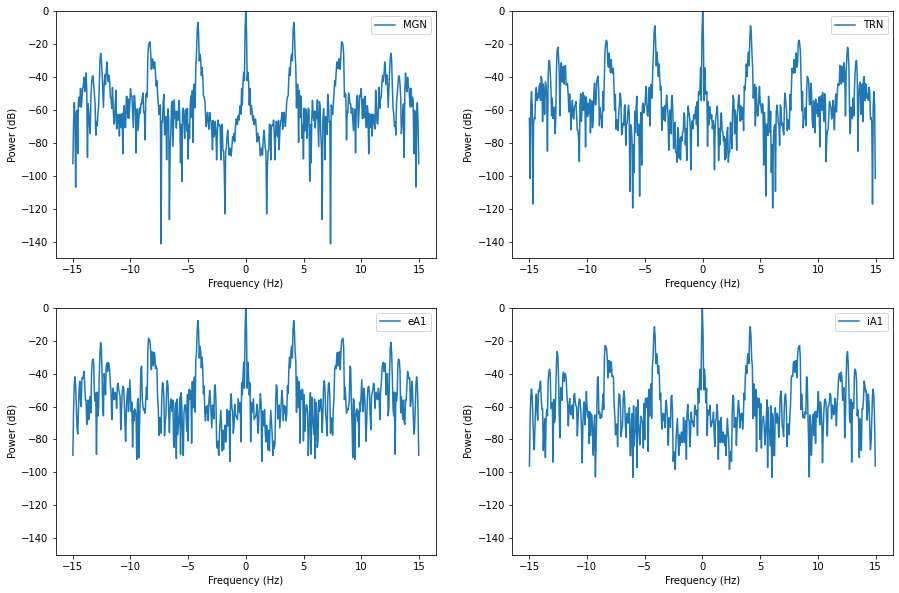

In [176]:
plotPowerSpectra(p)


**5 July 2022 - Stimulating the MGN for 100s**

`mgnstim` <br />
What happens when we stimulate the MGN for 200s?

`mgnstim-200s` <br />
The results are not v different. The problem is that the MGN and the TRN oscillate due to the strong coupling between them. Also, the activity in both the MGN and eA1 should be 20, the activity in the MGN can't be arbitrarily high.

`mgn20hz` <br />
In this experiment, the MGN is kept at 20Hz and the weight to the eA1 is regulated to cause 20Hz there. The MGN still oscillates. Might make sense to use a smaller noise, and high weight.

`mgn20hz-highweight` <br />
A w_th_stimscale=15 and nuX_stim~=4.67 gives reasonably good results. However, it is worth investigating if the MGN and the TRN can be less strongly couples to reduce oscillations in the MGN.

`weakcoupling` <br />
A weaker coupling in the Thalamus doesn't help. Intead a higher gamma with more inhibition is more effective.

`weakaone` <br />
Again, a higher gamma seems to help.

`highergamma` <br />
Makes sense to put the two findings together to run an exp with both gamma values higher.

`mgn20hz-tonotopic` <br />
There is a peculiar relationship between the weight from the MGN to the eA1 and the iA1. The difference being the a higher weight to the eA1 leads to lower activity.

`mgn20hz-lowera1gamma` <br />
A separate experiment called, `aone_lowergamma` was run to find a lower gamma value for the aone and used here to address oscillations. This did not help with the oscillations and also caused activiy in the eA1 and iA1 to be ~12Hz higher than needed (but this can probably be simply addressed by decreasing the bg noise).